In [1]:
import os
import csv
import yaml
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import numpy as np
import wandb
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from dataset import Dataset
from tools.test import test
from tools.train import train
from check_cuda import check_cuda
from models.ResnetFFN import ResnetFFN

from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# Define paths
csv_file_path = "./data/CodingChallenge_v2/car_imgs_4000.csv"
images_dir = "./data/CodingChallenge_v2/imgs"

# Initialize list to hold training data
images = []
scores_hood = []
scores_backdoor_left = []

IMG_H = 224
IMG_W = 224

In [3]:
# Set predetermined mean and std values 
mean_images = np.array([122.09624237, 123.38567456, 120.75862292]) / 255.0
std_images = np.array([61.13438223, 62.09970917, 65.60647365]) / 255.0

# Resize images, convert to torch.Tensor and normalize the dataset regarding predetermined mean and std values
transform_norm = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMG_H, IMG_W)),  # Resize images to (IMG_H x IMG_W)
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean_images, std_images)
])

In [4]:
# Read the CSV file
with open(csv_file_path, mode="r") as csv_file:
    csv_reader = csv.reader(csv_file)
    
    # Skip the header
    next(csv_reader)

    for row in csv_reader:
        filename, score_hood, score_backdoor_left = row
        image_path = os.path.join(images_dir, filename)

        # Check if the image file exists
        if os.path.exists(image_path):
            
            # Append image and perspective scores to the corresponding lists
            with Image.open(image_path) as img:
                images.append(np.array(transform_norm(img), dtype=np.float32))
                
            scores_hood.append(np.array(float(score_hood), dtype=np.float32))
            scores_backdoor_left.append(np.array(float(score_backdoor_left), dtype=np.float32))

# Check if some scores are NaN
for i in range(len(images)):
    if np.isnan(scores_hood[i]) or np.isnan(scores_backdoor_left[i]):
        print(f"Found NaN scores at index {i}")
        break
    
images = np.array(images) # Shape: (4000, 3, IMG_H, IMG_W)
scores_hood = np.array(scores_hood).reshape(-1, 1) # Shape: (4000, 1)
scores_backdoor_left = np.array(scores_backdoor_left).reshape(-1, 1) # Shape: (4000, 1)

# Test size of variables
print(f"Images Shape: {images.shape}")
print(f"Scores Hood Shape: {scores_hood.shape}")
print(f"Scores Backdoor Left Shape: {scores_backdoor_left.shape}")
print("")
print("Mean of Image Pixels: ", np.mean(images, axis=(0,2,3)), "   ->   [values should be near 0!]")
print("Standard Deviation of Image Pixels: ", np.std(images, axis=(0,2,3)), "   ->   [values should be near 1!]")
# print(f"Mean of images: {mean_images}")
# print(f"Std of images: {std_images}")


Images Shape: (4000, 3, 224, 224)
Scores Hood Shape: (4000, 1)
Scores Backdoor Left Shape: (4000, 1)

Mean of Image Pixels:  [-0.00146458 -0.00061618 -0.00030073]    ->   [values should be near 0!]
Standard Deviation of Image Pixels:  [1.026527  1.024326  1.0237782]    ->   [values should be near 1!]



IMPORTANT: Our dataset includes a lot of white pixels, which is due to the fact
            that the images are synthetically generated and have a lot of white backgrounds!


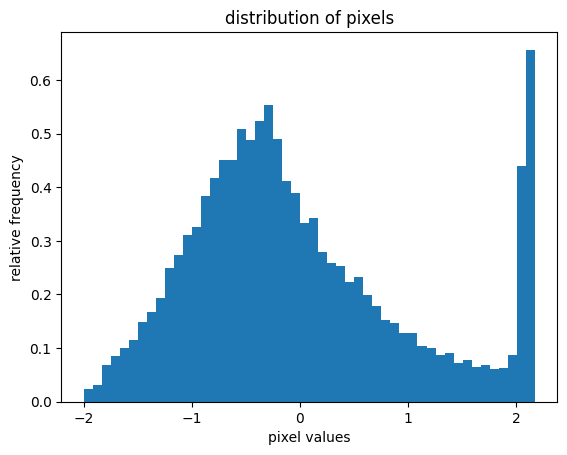

In [5]:
# plot the pixel values
plt.hist(images.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

print("""\nIMPORTANT: Our dataset includes a lot of white pixels, which is due to the fact
            that the images are synthetically generated and have a lot of white backgrounds!""")

In [6]:
# Analyze the perspective scores characteristics

scores_hood = np.array(scores_hood)
scores_backdoor_left = np.array(scores_backdoor_left)

print(f"Score hood: min={scores_hood.min()}, max={scores_hood.max()}, \
mean={scores_hood.mean()}, std={scores_hood.std()}, num_zeros={np.count_nonzero(scores_hood==0)}, \
mean_non_zero={np.mean(scores_hood[scores_hood!=0])}")

print(f"Score backdoor left: min={scores_backdoor_left.min()}, \
max={scores_backdoor_left.max()}, mean={scores_backdoor_left.mean()}, \
std={scores_backdoor_left.std()}, num_zeros={np.count_nonzero(scores_backdoor_left==0)}, \
mean_non_zero={np.mean(scores_backdoor_left[scores_backdoor_left!=0])}")

Score hood: min=0.0, max=0.9224276542663574, mean=0.3030319809913635, std=0.3825345039367676, num_zeros=2103, mean_non_zero=0.6389709711074829
Score backdoor left: min=0.0, max=0.9395412802696228, mean=0.3133678734302521, std=0.3722873628139496, num_zeros=2086, mean_non_zero=0.6548962593078613


In [7]:
# Convert lists to tensors and prepare input data 
X = torch.from_numpy(images) # Size: ([4000, 506, 674, 3])

# Concatenate the two scores into a single tensor as the model's output data
y = torch.from_numpy(np.concatenate((scores_hood, scores_backdoor_left), axis=1)) # Size: [(4000, 2)]

print("X size:", X.size(), "X type:", type(X), "X.dtype:", X.dtype)
print("y size:", y.size(), "y type:", type(y), "y.dtype:", y.dtype)

X size: torch.Size([4000, 3, 224, 224]) X type: <class 'torch.Tensor'> X.dtype: torch.float32
y size: torch.Size([4000, 2]) y type: <class 'torch.Tensor'> y.dtype: torch.float32


In [8]:
# check cuda availability
check_cuda()

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {device}")

CUDA is available! 
Number of GPUs: 1
Current CUDA device: 0 (NVIDIA GeForce RTX 2070 SUPER)
Python version: 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]

Device: cuda


In [9]:
# Define train, test and validation ratios
train_ratio = 0.8
test_ratio = 0.1
val_ratio = 0.1

# Split the data / Shuffle it and maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (1 - train_ratio), random_state=42, shuffle=True)

# Further split train_data into test and validation sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = test_ratio/(test_ratio + val_ratio), random_state=42, shuffle=True)

print("X_train size: ", X_train.size())
print("X_test size: ", X_test.size())
print("X_val size: ", X_val.size())

X_train size:  torch.Size([3200, 3, 224, 224])
X_test size:  torch.Size([400, 3, 224, 224])
X_val size:  torch.Size([400, 3, 224, 224])


In [10]:
# # Push torch.Tensors to CPU
# X_train, y_train = X_train.to('cpu', dtype=torch.float32), y_train.to('cpu', dtype=torch.float32)
# X_test, y_test = X_test.to('cpu', dtype=torch.float32), y_test.to('cpu', dtype=torch.float32)
# X_val, y_val = X_val.to('cpu', dtype=torch.float32), y_val.to('cpu', dtype=torch.float32)

# Create a custom dataset and push tensors to CPU
train_dataset = Dataset(X_train, y_train, 'cpu')
test_dataset = Dataset(X_test, y_test, 'cpu')
val_dataset = Dataset(X_val, y_val, 'cpu')

del X, y, X_train, y_train, X_test, y_test, X_val, y_val

In [11]:
# Show how much memory (VRAM) is allocated to GPU
gpu_memory_allocated = torch.cuda.memory_allocated(device)

# Convert memory from bytes to GB
gpu_memory_allocated_gb = gpu_memory_allocated / 1024**3

# Print the memory allocated to the GPU
print("GPU Memory Allocated:", gpu_memory_allocated_gb, "GB")

GPU Memory Allocated: 0.0 GB


In [12]:
# Set config

with open(os.getenv("CONFIG_DIR"), "r") as config_file:
    config_model = yaml.safe_load(config_file)

CNN-FCN

In [13]:
# Initialize W&B for RNN-Classifier
wandb.init(
    # set the wandb project where this run will be logged
    project = config_model["Project"]["project_name"],

    # track hyperparameters and run metadata
    config = dict(
        device = device,
        project_name = config_model["Project"]["project_name"],
        model_name = config_model["Model"]["model_name"],
        num_outputs = config_model["Model"]["num_outputs"],
        batch_first = config_model["Model"]["batch_first"],
        conv_channel = config_model["Model"]["conv_channel"],
        fc_hidden_dims = config_model["Model"]["fc_hidden_dims"],
        batch_size = config_model["Dataloader"]["batch_size"],
        shuffle = config_model["Dataloader"]["shuffle"],
        num_workers = config_model["Dataloader"]["num_workers"],
        pin_memory = config_model["Dataloader"]["pin_memory"],
        drop_last = config_model["Dataloader"]["drop_last"],
        optimizer = config_model["Optimizer"]["optimizer"],
        backbone_lr = float(config_model["Optimizer"]["backbone_lr"]),
        other_lr = float(config_model["Optimizer"]["other_lr"]),
        beta1 = config_model["Optimizer"]["beta1"],
        beta2 = config_model["Optimizer"]["beta2"],
        eps = float(config_model["Optimizer"]["eps"]),
        weight_decay = config_model["Optimizer"]["weight_decay"],
        amsgrad = config_model["Optimizer"]["amsgrad"],
        maximize = config_model["Optimizer"]["maximize"],
        foreach = config_model["Optimizer"]["foreach"],
        capturable = config_model["Optimizer"]["capturable"],
        differentiable = config_model["Optimizer"]["differentiable"],
        fused = config_model["Optimizer"]["fused"],
        scheduler = config_model["Scheduler"]["scheduler"],
        factor = config_model["Scheduler"]["factor"],
        patience = config_model["Scheduler"]["patience"],
        threshold = config_model["Scheduler"]["threshold"],
        threshold_mode = config_model["Scheduler"]["threshold_mode"],
        cooldown = config_model["Scheduler"]["cooldown"],
        min_lr = config_model["Scheduler"]["min_lr"],
        verbose = config_model["Scheduler"]["verbose"],
        loss = config_model["Loss"]["loss"],
        num_epochs = config_model["Training"]["num_epochs"],
        save_dir = config_model["Training"]["save_dir"],
        save_period = config_model["Training"]["save_period"],
        log_period = config_model["Training"]["log_period"],
        log_dir = config_model["Training"]["log_dir"],
        log_file = config_model["Training"]["log_file"],
        log_level = config_model["Training"]["log_level"],
        seed = config_model["Training"]["seed"]
    ),
)

# initialize config
config = wandb.config

model = ResnetFFN(config).to(device)
print(model)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: onat-inak (onat-inak-). Use `wandb login --relogin` to force relogin


ResnetFFN(
  (preprocess): ImageClassification(
      crop_size=[224]
      resize_size=[256]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), b

INITIALIZE DATA LOADERS

In [14]:
# Divide train and test dataset into batches
train_loader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=config.shuffle,num_workers=config.num_workers,
    pin_memory = config.pin_memory, drop_last=config.drop_last
)
test_loader = DataLoader(
    test_dataset, batch_size=config.batch_size, shuffle=config.shuffle,num_workers=config.num_workers,
    pin_memory = config.pin_memory, drop_last=config.drop_last
)
val_loader = DataLoader(
    val_dataset, batch_size=config.batch_size, shuffle=config.shuffle,num_workers=config.num_workers,
    pin_memory = config.pin_memory, drop_last=config.drop_last
)

# Check whether data is splitted correctly -> X_.shape: (batch, seq, encoding), y_.shape: (batch)
for i, (X_, y_) in enumerate(train_loader):
    print("X.shape:", X_.shape, "   y.shape: ", y_.shape)
    break


X.shape: torch.Size([64, 3, 224, 224])    y.shape:  torch.Size([64, 2])


TRAINING

In [15]:
# Observe initial performance of the model without any training
model.eval()
test(model, test_loader, device, config.project_name, save_model=False)
model.train();

Mean Absolute Error (MAE): 0.3928954601287842
Mean Squared Error (MSE): 0.17316581308841705


In [16]:
# Loss and optimizer
criterion = nn.MSELoss()

regularizer = torch.nn.L1Loss()

backbone_params = list(model.backbone.parameters())
other_params = [param for name, param in model.named_parameters() if "backbone" not in name]

# Define different learning rates
backbone_lr = config.backbone_lr
other_lr = config.other_lr

# Create parameter groups
param_groups = [
    {'params': backbone_params, 'lr': backbone_lr},
    {'params': other_params, 'lr': other_lr}
]

optimizer = torch.optim.AdamW(
    param_groups,
    betas=(config.beta1, config.beta2),
    eps=config.eps,
    weight_decay=config.weight_decay,
    amsgrad=config.amsgrad,
    maximize=config.maximize,
    foreach=config.foreach,
    capturable=config.capturable,
    differentiable=config.differentiable,
    fused=config.fused,
)

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=config.gamma)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=config.factor, patience=config.patience,
                                                       threshold=config.threshold, threshold_mode=config.threshold_mode,
                                                       cooldown=config.cooldown, min_lr=[config.min_lr, config.min_lr],
                                                       verbose=config.verbose)

print("optimizer: ", optimizer)
print("")
print("loss function: ", criterion)
print("")
print("scheduler", scheduler)
print("")

optimizer:  AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: False
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0.01

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: False
    fused: None
    lr: 0.003
    maximize: False
    weight_decay: 0.01
)

loss function:  MSELoss()

scheduler <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fb5186c1e10>



/home/onatinak/anaconda3/envs/perspective_regressor/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [17]:
# Train the model
train(model, train_loader, val_loader, criterion, optimizer, scheduler, config)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30], Step [10/1500], Current Batch [10/50], Train Loss: 0.1474
backbone_lr:  1e-05 other_lr:  0.003
Epoch [1/30], Step [20/1500], Current Batch [20/50], Train Loss: 0.1174
backbone_lr:  1e-05 other_lr:  0.003
Epoch [1/30], Step [30/1500], Current Batch [30/50], Train Loss: 0.0889
backbone_lr:  1e-05 other_lr:  0.003
Epoch [1/30], Step [40/1500], Current Batch [40/50], Train Loss: 0.0823
backbone_lr:  1e-05 other_lr:  0.003
Epoch [1/30], Step [50/1500], Current Batch [50/50], Train Loss: 0.0582
backbone_lr:  1e-05 other_lr:  0.003
Validation Loss: 0.05238 

Epoch [2/30], Step [10/1500], Current Batch [60/50], Train Loss: 0.0487
backbone_lr:  1e-05 other_lr:  0.003
Epoch [2/30], Step [20/1500], Current Batch [70/50], Train Loss: 0.0451
backbone_lr:  1e-05 other_lr:  0.003
Epoch [2/30], Step [30/1500], Current Batch [80/50], Train Loss: 0.0395
backbone_lr:  1e-05 other_lr:  0.003
Epoch [2/30], Step [40/1500], Current Batch [90/50], Train Loss: 0.0287
backbone_lr:  1e-05 other_lr:

In [18]:
# Test the model -> no need to compute gradients (for memory efficiency)
test(model, test_loader, device, config.project_name, save_model=True)

Mean Absolute Error (MAE): 0.06719446182250977
Mean Squared Error (MSE): 0.017814571037888527


In [19]:
# Print learnable parameter values after training
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

backbone.0.weight tensor([[[[ 1.3418e-02,  1.4710e-02, -1.5350e-02,  ..., -4.1008e-02,
           -4.3214e-02, -7.0927e-02],
          [ 4.2226e-03,  5.9071e-03,  1.4939e-02,  ...,  2.0398e-03,
           -2.1167e-02, -3.8757e-02],
          [ 2.2421e-02,  2.3637e-02,  1.6080e-02,  ...,  1.0259e-01,
            6.2343e-02,  5.1713e-02],
          ...,
          [-9.0079e-04,  2.7709e-02, -1.0210e-02,  ..., -1.2740e-01,
           -7.6847e-02,  7.6818e-03],
          [ 3.5648e-03,  4.7931e-02,  6.1940e-02,  ...,  2.4094e-02,
           -3.3859e-02, -1.5821e-02],
          [-8.0096e-02, -3.2329e-02, -1.7932e-02,  ...,  3.5148e-02,
            2.2190e-02,  1.5179e-03]],

         [[-1.8334e-02,  1.1472e-02,  2.3866e-02,  ...,  5.3649e-02,
            4.3850e-02, -9.6251e-03],
          [-7.6167e-03,  1.8952e-02,  6.7976e-02,  ...,  1.5942e-01,
            1.4582e-01,  1.1976e-01],
          [-4.5916e-02, -7.6036e-02, -8.9697e-02,  ...,  1.2088e-01,
            1.6676e-01,  1.7594e-01],
  

In [20]:
wandb.finish()

MAE,█▁
MSE,█▁
backbone_lr,███████████▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
current_batch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
other_lr,███████████▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE,0.06719
MSE,0.01781
backbone_lr,0.0
